In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
print(os.path.abspath(os.curdir))

/home2/gridsan/glcf411/sigsep_mlsp


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pickle
from tqdm import tqdm

get_pow = lambda s: np.mean(np.abs(s)**2)
get_sinr = lambda s, i: 10*np.log10(get_pow(s)/get_pow(i))

In [3]:
from src import unet_model as unet

---

In [4]:
import tensorflow as tf

In [5]:
ns, nb = 11, 5
w1, w2 = pickle.load(open(f'stats/cyclo_example_filter_{ns}_{nb}.pickle','rb'))

import random
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

sig_len0, sig_len = (ns*nb)*10, 256

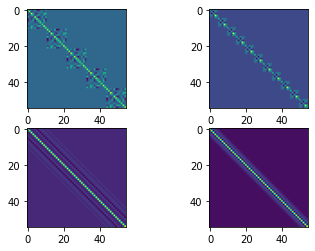

In [6]:
cov1 = np.matmul(w1, w1.conj().T)
cov2 = np.matmul(w2, w2.conj().T)

cov1_r = np.zeros((sig_len, sig_len))
for ii in range(ns):
    cov1_r += cov1[ii:ii+sig_len, ii:ii+sig_len]
cov1_r = cov1_r / ns

cov2_r = np.zeros((sig_len, sig_len))
for ii in range(nb):
    cov2_r += cov2[ii:ii+sig_len, ii:ii+sig_len]
cov2_r = cov2_r / nb

plt.subplot(221)
plt.imshow(cov1[:55,:55])

plt.subplot(222)
plt.imshow(cov2[:55,:55])

plt.subplot(223)
plt.imshow(cov1_r[:55,:55])

plt.subplot(224)
plt.imshow(cov2_r[:55,:55])

In [7]:
all_stat_param = {}
for sinr_db in tqdm(np.arange(-6, 7, 1.5)):
    for tau_s in range(ns):
        for tau_b in range(nb):
            Cyy_inv, log_det_Cyy, W, Ce = pickle.load(open(f'stats/cyclo_param/filters_param_taus{tau_s}_taub{tau_b}_sinr{sinr_db:.01f}.pickle','rb'))
            all_stat_param[(tau_s, tau_b, sinr_db)] = (Cyy_inv, log_det_Cyy, W, Ce)

100%|██████████| 9/9 [01:37<00:00, 10.83s/it]


In [8]:
from scipy import linalg

cov_s, cov_b = cov1_r, cov2_r
cov_true_s, cov_true_b = cov1, cov2

window_len = sig_len
def lmmse(sig_mixture, sinr_db):
    sinr = 10**(sinr_db/10)
    
    scaled_Cbb = cov_b * 1/sinr
    Cyy = cov_s + scaled_Cbb + 0.01*np.eye(window_len, dtype=complex)
    Csy = cov_s.copy()

    U,S,Vh = np.linalg.svd(Cyy,hermitian=True)
    sthr_idx = np.linalg.matrix_rank(Cyy) + 1
    Cyy_inv = np.matmul(U[:,:sthr_idx], np.matmul(np.diag(1.0/(S[:sthr_idx])), U[:,:sthr_idx].conj().T))
    W = np.matmul(Csy,Cyy_inv)
    
    s_est_windows = np.matmul(W, sig_mixture.reshape(-1, window_len).T).T
    s_est = s_est_windows.flatten()
    
    return s_est

def sync_mmse(sig_mixture, sinr_db, tau_b, tau_s):
    Css = cov_true_s[tau_s:tau_s+window_len, tau_s:tau_s+window_len]
    Cbb = cov_true_b[tau_b:tau_b+window_len, tau_b:tau_b+window_len]
    
    sinr = 10**(sinr_db/10)
    scaled_Cbb = Cbb * 1/sinr
    Cyy = Css + scaled_Cbb + 0.01*np.eye(window_len, dtype=complex)
    Csy = Css.copy()
    
    U,S,Vh = np.linalg.svd(Cyy,hermitian=True)
    sthr_idx = np.linalg.matrix_rank(Cyy) + 1
    Cyy_inv = np.matmul(U[:,:sthr_idx], np.matmul(np.diag(1.0/(S[:sthr_idx])), U[:,:sthr_idx].conj().T))
    W = np.matmul(Csy,Cyy_inv)
    
    s_est_windows = np.matmul(W, sig_mixture.reshape(-1, window_len).T).T
    s_est = s_est_windows.flatten()
    
    err = Csy - np.matmul(W, Csy.conj().T)
    return s_est, err

def mmse(sig_mixture):
    sig_mixture = sig_mixture.reshape(-1,1)
    all_log_prob = []
    all_mmse = []
    for ii in range(ns):
        for jj in range(nb):
            for nn,kk in enumerate(np.arange(-6, 7, 3)):
                
                param = all_stat_param[(ii,jj,kk)]
                cyy_inv, det_param, W, _ = param
                all_log_prob.append(-0.5*np.log(2*np.pi) - 0.5*det_param + (-0.5 * np.matmul(sig_mixture.conj().T, np.matmul(cyy_inv, sig_mixture)) ))
                
                sig_est = np.matmul(W, sig_mixture.reshape(-1, window_len).T).T
                sig_est = sig_est.squeeze()
                all_mmse.append(sig_est)
                
    all_log_prob = np.array(all_log_prob).squeeze()
    all_log_prob = all_log_prob - np.max(all_log_prob.real)
    all_prob = np.exp(all_log_prob)
    all_prob = all_prob / np.sum(all_prob)
    
    all_mmse = np.array(all_mmse)
    
    return np.sum(all_prob.reshape(-1,1)*all_mmse, axis=0)

In [10]:
all_nn_models = []
for long_k_sz in [101, 11, 3]:
    nn_model = unet.get_unet_model0((sig_len, 2), k_sz=3, long_k_sz=long_k_sz, k_neurons=32)
    nn_model.load_weights(f'models/unet_cyclo_models/CycloA_CycloB_256_K{long_k_sz}/checkpoint')
    all_nn_models.append(nn_model)

In [11]:
random.seed(123123)
np.random.seed(123123)

all_mse = []
n_per_sinr = 1000
all_sinr_ax = np.arange(-6,7,3)
all_err = []

for target_sinr in tqdm(all_sinr_ax):
    for idx in range(n_per_sinr):
        c1 = 1./np.sqrt(2) * (np.random.randn(sig_len0) + 1j*np.random.randn(sig_len0))
        c2 = 1./np.sqrt(2) * (np.random.randn(sig_len0) + 1j*np.random.randn(sig_len0))

        sig1 = np.matmul(w1, c1)
        sig2 = np.matmul(w2, c2)
        
        roll_idx1 = np.random.randint(len(sig1))
        roll_idx2 = np.random.randint(len(sig2))
        sig1 = np.roll(sig1, -roll_idx1)[:sig_len]
        sig2 = np.roll(sig2, -roll_idx2)[:sig_len]

        coeff = np.sqrt(np.mean(np.abs(sig1)**2)/(np.mean(np.abs(sig2)**2)*(10**(target_sinr/10))))
        
        noise = 0.1 * 1./np.sqrt(2) * (np.random.randn(sig_len) + 1j*np.random.randn(sig_len))
        sig_mixture = sig1 + sig2*coeff + noise
        
        sig1_lmmse = lmmse(sig_mixture, target_sinr)
        sig1_smmse, err = sync_mmse(sig_mixture, target_sinr, roll_idx2 % nb, roll_idx1 % ns)
        all_err.append((np.diag(err)))
        sig1_mmse = mmse(sig_mixture)
        
        mixture_bandsT = sig_mixture.reshape(-1, sig_len)
        mixture_bands_compT = np.dstack((mixture_bandsT.real, mixture_bandsT.imag))
        
        mse_arr = []
        with tf.device('CPU:0'):
            for nn_model in all_nn_models:
                out1_est = nn_model(mixture_bands_compT).numpy()
                sig1_est = (out1_est[:,:,0] + 1j*out1_est[:,:,1]).flatten()
                
                mse_arr.append(get_pow(sig1-sig1_est))
            
        mse_arr.append(get_pow(sig1-sig1_lmmse))
        mse_arr.append(get_pow(sig1-sig1_smmse))
        mse_arr.append(get_pow(sig1-sig1_mmse))

        all_mse.append(mse_arr)

100%|██████████| 5/5 [26:08<00:00, 313.64s/it]


In [14]:
all_mse = np.array(all_mse)

pickle.dump(all_mse[:,-3], open('output/Cyclo_MSE_LMMSE.pickle', 'wb'))
pickle.dump(all_mse[:,-2], open('output/Cyclo_MSE_SyncMMSE.pickle', 'wb'))
pickle.dump(all_mse[:,-1], open('output/Cyclo_MSE_MMSE.pickle', 'wb'))

pickle.dump(all_mse[:,0], open('output/Cyclo_MSE_UnetK101.pickle', 'wb'))
pickle.dump(all_mse[:,1], open('output/Cyclo_MSE_UnetK11.pickle', 'wb'))
pickle.dump(all_mse[:,2], open('output/Cyclo_MSE_UnetK3.pickle', 'wb'))

In [15]:
plt.rcParams['font.size'] = '14'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.markeredgewidth'] = 2
plt.rcParams["font.family"] = "serif"

[-5.49225878 -5.19380167 -5.04062669 -3.16439091 -5.80592102 -5.80428376]


Text(0, 0.5, 'MSE($s$,$\\hat{s}$) [dB]')

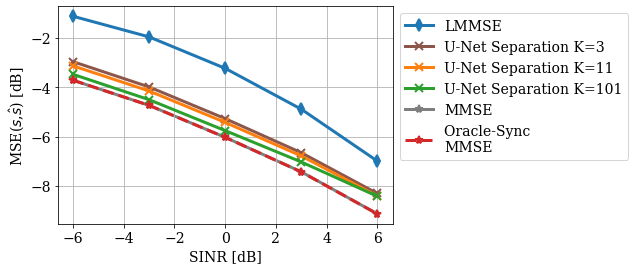

In [22]:
all_mse = np.array(all_mse)
print(10*np.log10(all_mse.mean(axis=0)))

plt.plot(all_sinr_ax, 10*np.log10(all_mse[:,-3].reshape(-1,n_per_sinr).mean(axis=-1)), 'd-', label='LMMSE')

plt.plot(all_sinr_ax, 10*np.log10(all_mse[:,2].reshape(-1,n_per_sinr).mean(axis=-1)), 'x-', label='U-Net Separation K=3', color='tab:brown')
plt.plot(all_sinr_ax, 10*np.log10(all_mse[:,1].reshape(-1,n_per_sinr).mean(axis=-1)), 'x-', label='U-Net Separation K=11', color='tab:orange')
plt.plot(all_sinr_ax, 10*np.log10(all_mse[:,0].reshape(-1,n_per_sinr).mean(axis=-1)), 'x-', label='U-Net Separation K=101', color='tab:green')

plt.plot(all_sinr_ax, 10*np.log10(all_mse[:,-1].reshape(-1,n_per_sinr).mean(axis=-1)), '*-', label='MMSE', color='tab:gray', zorder=0)
plt.plot(all_sinr_ax, 10*np.log10(all_mse[:,-2].reshape(-1,n_per_sinr).mean(axis=-1)), '*--', label='Oracle-Sync \nMMSE', color='tab:red')

plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('SINR [dB]')
plt.ylabel('MSE($s$,$\hat{s}$) [dB]')